In [54]:
import os
from typing import List, Tuple
import warnings
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


warnings.filterwarnings("ignore")

In [55]:
file_path = 'data/testData.xlsx'
data = pd.read_excel(file_path)
data = data.set_index('datetime')
data['date'] = data.index.date
columns = ['date'] + [col for col in data.columns if col != 'date']
data = data[columns]
for i in range(0, len(data), 38):
    date_to_fill = data.index[i].strftime('%Y-%m-%d')
    data.iloc[i:i+38, data.columns.get_loc('date')] = date_to_fill
print(data.head(40))

                           date   open   high    low  close  volume
datetime                                                           
2022-07-01 08:45:00  2022-07-01  14656  14702  14512  14566   27167
2022-07-01 09:15:00  2022-07-01  14567  14622  14493  14520   21725
2022-07-01 09:45:00  2022-07-01  14520  14568  14476  14538   16847
2022-07-01 10:15:00  2022-07-01  14539  14549  14380  14386   19716
2022-07-01 10:45:00  2022-07-01  14388  14403  14281  14288   23082
2022-07-01 11:15:00  2022-07-01  14288  14319  14226  14238   16337
2022-07-01 11:45:00  2022-07-01  14239  14320  14230  14246   13369
2022-07-01 12:15:00  2022-07-01  14246  14274  14211  14237   10962
2022-07-01 12:45:00  2022-07-01  14235  14243  14181  14184   10873
2022-07-01 13:15:00  2022-07-01  14184  14194  14128  14175   23531
2022-07-01 15:00:00  2022-07-01  14202  14235  14164  14219    7170
2022-07-01 15:30:00  2022-07-01  14218  14248  14217  14220    3302
2022-07-01 16:00:00  2022-07-01  14221  14271  1

In [56]:
initial_capital = 100000000
current_cumulative_return = 1
slippage = 0.001
commission = 50
tax_rate = 0.00002
unit_dollar = 200
short_window = 5
middle_window = 20
long_window = 120
window_size = 14
#Use short-term EMA, midterm EMA and long-term to capture the trend

In [57]:
data['short_ema'] = data['close'].ewm(span=short_window, adjust=False).mean()
data['middle_ema'] = data['close'].ewm(span=middle_window, adjust=False).mean()
data['long_ema'] = data['close'].ewm(span=long_window, adjust=False).mean()
data['typical price'] = (data['high'] + data['low'] + data['close']) / 3
data['money flow'] = data['typical price'] * data['volume']
data['positive cash flow'] = data['money flow'].where(data['typical price'] > data['typical price'].shift(1), 0).rolling(window=window_size).sum()
data['negative cash flow'] = data['money flow'].where(data['typical price'] < data['typical price'].shift(1), 0).rolling(window=window_size).sum()
data['money ratio'] = data['positive cash flow'] / data['negative cash flow']
data['mfi'] = 100 - (100 / (1 + data['money ratio']))
data['avg_volume'] = data['volume'].shift(1).rolling(window=5).mean()
high_low = data['high'] - data['low']
high_close = np.abs(data['high'] - data['close'].shift(1))
low_close = np.abs(data['low'] - data['close'].shift(1))
tr_df = pd.DataFrame({'high_low': high_low, 'high_close': high_close, 'low_close': low_close})
tr = tr_df.max(axis=1)
n = 14
atr_values = tr.rolling(window=n).mean()
data['atr'] = atr_values

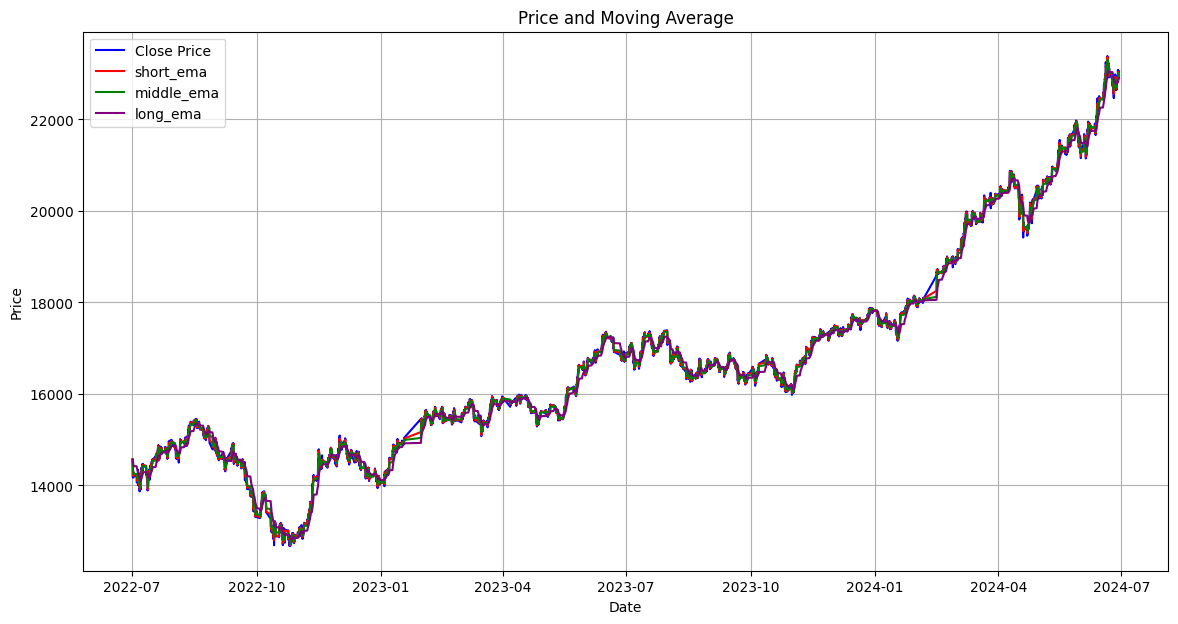

In [58]:
plt.figure(figsize=(14, 7))
plt.plot(data['close'], label='Close Price', color='blue')
plt.plot(data['short_ema'], label='short_ema', color='red')
plt.plot(data['middle_ema'], label='middle_ema', color='green')
plt.plot(data['long_ema'], label='long_ema', color='purple')
plt.title('Price and Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

In [59]:

data['change'] = data['close'].diff()
data['up_wave'] = pd.NA
data['down_wave'] = pd.NA
data['max_up_wave'] = pd.NA
data['check'] = None
data['impulse'] = None
data.fillna(0, inplace=True)
for i in tqdm(range(1, len(data))):
    if data['change'].iloc[i] == 0:
        if data['up_wave'].iloc[i - 1] == 0:
            negative_change = data['change'].iloc[i]
            data['down_wave'].iloc[i] =  + data['down_wave'].iloc[i - 1] + negative_change
            data['up_wave'].iloc[i] = 0
            data['max_up_wave'].iloc[i] = data['max_up_wave'].iloc[i -1]
            if abs(data['down_wave'].iloc[i]) > data['max_up_wave'].iloc[i]:
                if data['check'].iloc[i - 1] == True:
                    data['impulse'].iloc[i] = True
                    data['check'] = None
                else:
                    data['check'].iloc[i] = True
            else:
                data['check'] = None
        elif data['down_wave'].iloc[i - 1] == 0:        
            positive_change = data['change'].iloc[i]
            data['up_wave'].iloc[i] =  + data['up_wave'].iloc[i - 1] + positive_change
            data['down_wave'].iloc[i] = 0
            data['max_up_wave'].iloc[i] = data['up_wave'].iloc[i]
            if data['check'].iloc[i - 1] == True:
                data['check'].iloc[i] = True
    elif data['change'].iloc[i] > 0:
        positive_change = data['change'].iloc[i]
        data['up_wave'].iloc[i] =  + data['up_wave'].iloc[i - 1] + positive_change
        data['down_wave'].iloc[i] = 0
        data['max_up_wave'].iloc[i] = data['up_wave'].iloc[i]
        if data['check'].iloc[i - 1] == True:
            data['check'].iloc[i] = True
    elif data['change'].iloc[i] < 0:
        negative_change = data['change'].iloc[i]
        data['down_wave'].iloc[i] =  + data['down_wave'].iloc[i - 1] + negative_change
        data['up_wave'].iloc[i] = 0
        data['max_up_wave'].iloc[i] = data['max_up_wave'].iloc[i -1]
        if abs(data['down_wave'].iloc[i]) > data['max_up_wave'].iloc[i]:
            if data['check'].iloc[i - 1] == True:
                data['impulse'].iloc[i] = True
                data['check'] = None
            else:
                data['check'].iloc[i] = True
        else:
            data['check'] = None

if "data/full_information.xlsx" not in os.listdir():
    data.to_excel("data/full_information.xlsx")
else:
    pass

100%|██████████| 18431/18431 [00:08<00:00, 2074.84it/s]


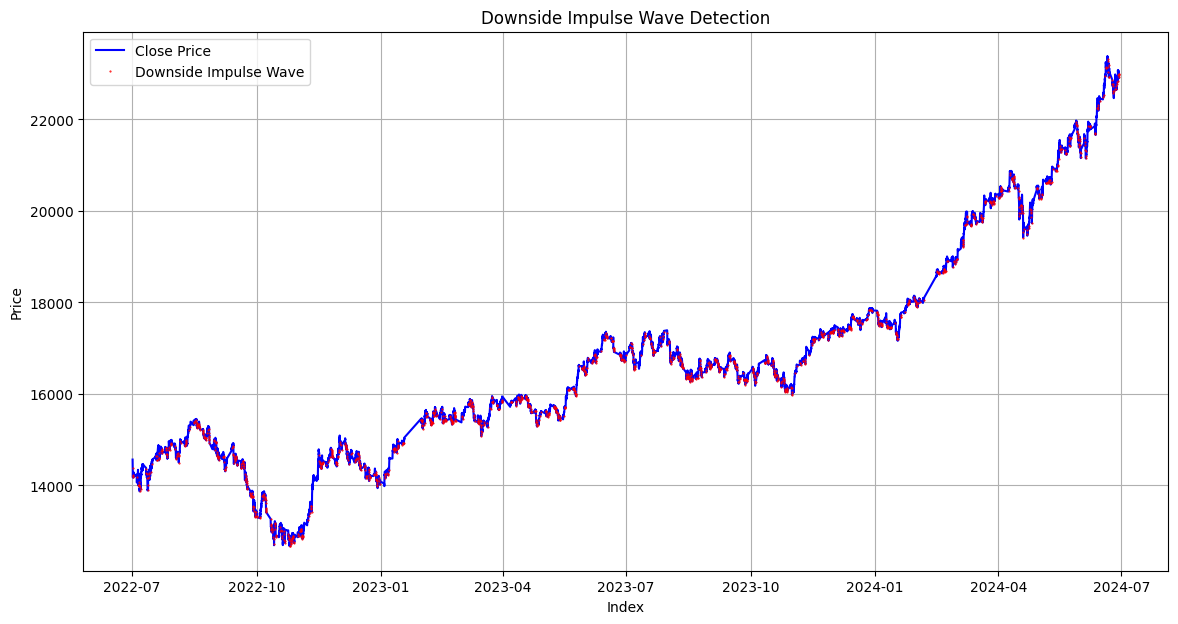

In [60]:
plt.figure(figsize=(14, 7))
plt.plot(data['close'], label='Close Price', color='blue')
plt.plot(
    data[data['impulse'] == True].index, 
    data['close'][data['impulse'] == True], 
    'ro',
    markersize=0.5,
    label='Downside Impulse Wave'
)
plt.title('Downside Impulse Wave Detection')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
trade_df = pd.DataFrame(columns=['Entry Datetime', 'Condition', 'Entry Price', 'Exit Datetime', 'Exit Price', 'Trade Profit', 'Net Profit', 'Trade Return'])
cumulative_return_tracking = pd.DataFrame(index=data.index,columns = ['Cumulative Return'])
cumulative_return_tracking['Cumulative Return'].iloc[0] = current_cumulative_return

In [62]:
file_path ='data/settlementDate.xlsx'
sd = pd.read_excel(file_path)
sd.columns = ['No.', 'settlementDate', 'futures', 'settlementPrice']
sd = sd.drop('No.', axis=1)
print(sd.head())

  settlementDate   futures  settlementPrice
0     2024-07-26  202407W4            22069
1     2024-07-17    202407            23680
2     2024-07-10  202407W2            23996
3     2024-07-03  202407W1            23138
4     2024-06-26  202406W4            22965


In [63]:
bool_ = [False if 'W' in str(i) else True for i in sd['futures']]
settlementDate = [str(i).replace('/','-') for i in list(sd[bool_]['settlementDate'])]
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]
print(settlementDate[-5:])

[datetime.date(1999, 1, 21), datetime.date(1998, 12, 17), datetime.date(1998, 11, 19), datetime.date(1998, 10, 22), datetime.date(1998, 9, 17)]


In [64]:
time_arr = np.array(data.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]
print(date_arr[:5])

[datetime.date(2022, 7, 1), datetime.date(2022, 7, 1), datetime.date(2022, 7, 1), datetime.date(2022, 7, 1), datetime.date(2022, 7, 1)]


In [65]:
import datetime


def condition(
    data: pd.DataFrame,
    settlementDate: List[int],
    daily_trade: bool,
    date_arr: List[datetime.date],
    k: int,
    scenario: str
) -> Tuple[bool]:
    """
    Entry condition for the trading strategy.
    """
    if scenario == "entry":
        long = (
            data['short_ema'].iloc[k - 2] > data['middle_ema'].iloc[k - 2] > data['long_ema'].iloc[k - 2]
        ) and (
            data['short_ema'].iloc[k - 1] > data['middle_ema'].iloc[k - 1] > data['long_ema'].iloc[k - 1]
        ) and (
            data['short_ema'].iloc[k] > data['middle_ema'].iloc[k] > data['long_ema'].iloc[k]
        ) and (
            data['high'].iloc[k] > data['high'].iloc[k - 1] > data['high'].iloc[k - 2]
        ) and (
            data['low'].iloc[k] > data['low'].iloc[k - 1] > data['low'].iloc[k - 2]
        ) and (
            80 >data['mfi'].iloc[k] > 50
        ) and (
            data['volume'].iloc[k] > data['avg_volume'].iloc[k]
        )
        short = (
            data['long_ema'].iloc[k - 2] > data['middle_ema'].iloc[k - 2] > data['short_ema'].iloc[k - 2]
        ) and (
            data['long_ema'].iloc[k - 1] > data['middle_ema'].iloc[k - 1] > data['short_ema'].iloc[k - 1]
        ) and (
            data['long_ema'].iloc[k] > data['middle_ema'].iloc[k] > data['short_ema'].iloc[k]
        ) and (
            data['impulse'].iloc[k] == True
        ) and (
            20 < data['mfi'].iloc[k] < 50
        ) and (
            data['volume'].iloc[k] < data['avg_volume'].iloc[k]
        )
        cond = (date_arr[k] not in settlementDate) and (daily_trade is None)

    elif scenario == "exit":
        long = (
            data['short_ema'].iloc[j] < data['middle_ema'].iloc[j] < data['long_ema'].iloc[j]
        ) or (
            data['mfi'].iloc[j] > 90
        )
        short = (
            data['long_ema'].iloc[j] < data['middle_ema'].iloc[j] < data['short_ema'].iloc[j]
        ) or (
            data['mfi'].iloc[j] < 20
        )
        cond = date_arr[j] in settlementDate

    else:
        raise ValueError("Invalid scenario.")

    return long, short, cond


Condition = None
daily_trade = None
buy = []
sell = []
sellshort = []
buytocover = []
returns = []

for i in tqdm(range(3, len(data))):

    if i == len(data)-1:
        break
    
    if data['date'].iloc[i] != data['date'].iloc[i - 1]:
        daily_trade = None

    # entry condition
    entry_long, entry_short, entry_condition = condition(data, settlementDate, daily_trade, date_arr, i, "entry")

    if Condition == None:

        if entry_long and entry_condition:
            Condition = 'B'
            t = i + 1
            entry_price = data['open'].iloc[t] * (1 + slippage)
            l_stop_loss = data['atr'].iloc[t] * 2
            l_take_profit = data['atr'].iloc[t] * 2
            new_row = {'Entry Datetime' : data.index[t], 'Original Price' : data['open'].iloc[t], 'Condition' : 'B', 'Entry Price' : entry_price}
            buy.append(t)
            daily_trade = True 
        
            for j in range(t + 1, len(data)):
                exit_long, exit_short, exit_condition = condition(
                    data, settlementDate, daily_trade, date_arr, j, "exit"
                )

                if exit_long or exit_condition or (data['close'].iloc[j] <=  entry_price - l_stop_loss) or (data['close'].iloc[j] >=  entry_price + l_take_profit):
                    exit_price = min(max(data['close'].iloc[j] * (1 - slippage), data['open'].iloc[t] - l_stop_loss), data['open'].iloc[t] + l_take_profit)
                    new_row['Exit Datetime'] = data.index[j]
                    new_row['Exit Price'] = exit_price
                    amount = (initial_capital * 0.5) // (entry_price * unit_dollar)  # 50% of the initial capital
                    trade_profit = (exit_price - entry_price) * unit_dollar * amount
                    net_profit = trade_profit - commission - exit_price * unit_dollar * tax_rate - entry_price * unit_dollar * tax_rate
                    trade_return = (net_profit / (entry_price * unit_dollar * amount))
                    current_cumulative_return += trade_return
                    cumulative_return_tracking['Cumulative Return'].iloc[j] = current_cumulative_return
                    new_row['Trade Profit'] = trade_profit
                    new_row['Net Profit'] = net_profit
                    new_row['Trade Return'] = trade_return
                    new_row['Amount'] = amount
                    new_row_df = pd.DataFrame([new_row])
                    trade_df = pd.concat([trade_df, new_row_df], ignore_index=True)
                    Condition = None
                    break

        elif entry_short and entry_condition:
            Condition = 'S'
            t = i + 1
            entry_price = data['open'].iloc[t] * (1 - slippage)
            s_stop_loss = data['atr'].iloc[t] * 0.5
            s_take_profit = data['atr'].iloc[t] * 0.5
            new_row = {'Entry Datetime' : data.index[t], 'Original Price' : data['open'].iloc[t], 'Condition' : 'S', 'Entry Price' : entry_price}
            sellshort.append(t)
            daily_trade = True 

            for j in range(t + 1, len(data)):
                exit_long, exit_short, exit_condition = condition(
                    data, settlementDate, daily_trade, date_arr, j, "exit"
                )

                if exit_short or exit_condition or (data['close'].iloc[j] >=  entry_price + s_stop_loss) or (data['close'].iloc[j] <=  entry_price - s_take_profit):
                    exit_price = max(min(data['close'].iloc[j] * (1 + slippage), data['open'].iloc[t] + s_stop_loss), data['open'].iloc[t] - s_take_profit)
                    new_row['Exit Datetime'] = data.index[j]
                    new_row['Exit Price'] = exit_price
                    amount = (initial_capital * 0.1) // (entry_price * unit_dollar)
                    trade_profit = (exit_price - entry_price) * unit_dollar * amount
                    net_profit = trade_profit - commission - exit_price * unit_dollar * tax_rate - entry_price * unit_dollar * tax_rate
                    trade_return = (net_profit / (entry_price * unit_dollar * amount))
                    current_cumulative_return += trade_return
                    cumulative_return_tracking['Cumulative Return'].iloc[j] = current_cumulative_return
                    new_row['Trade Profit'] = trade_profit
                    new_row['Net Profit'] = net_profit
                    new_row['Trade Return'] = trade_return
                    new_row['Amount'] = amount
                    new_row_df = pd.DataFrame([new_row])
                    trade_df = pd.concat([trade_df, new_row_df], ignore_index=True)
                    Condition = None
                    break

trade_df.to_excel("data/trade_record.xlsx")

100%|█████████▉| 18428/18429 [00:01<00:00, 14876.26it/s]


(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  2.,  1.,  1.,  2.,  2.,
         1.,  1.,  2.,  2.,  6.,  0.,  9.,  6.,  4.,  5.,  2.,  5.,  5.,
         8.,  6.,  1.,  2.,  1.,  2.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,
         0.,  1.,  2.,  1.,  1.,  3.,  2.,  5.,  8.,  3.,  3.,  2.,  1.,
         1.,  2.,  4.,  4.,  6.,  8., 10., 12., 11., 10.,  8.,  7.,  5.,
         2.,  1.,  3.,  2.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  2.,  2.,
         1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.]),
 array([-9.35721567e-03, -9.20179443e-03, -9.04637319e-03, -8.89095195e-03,
        -8.73553071e-03, -8.58010947e-03, -8.42468823e-03, -8.26926699e-03,
        -8.11384575e-03, -7.95842451e-03, -7.80300327e-03, -7.64758203e-03,
        -7.49216079e-03, -7.33673955e-03, -7.18131831e-03, -7.02589707e-03,
        -6.87047583e-03, -6.71505459e-03, -6.55963335e-03, -6.40421211e-03,
        -6.24879087e-03, -6.09336963e-03, -5.93794839e

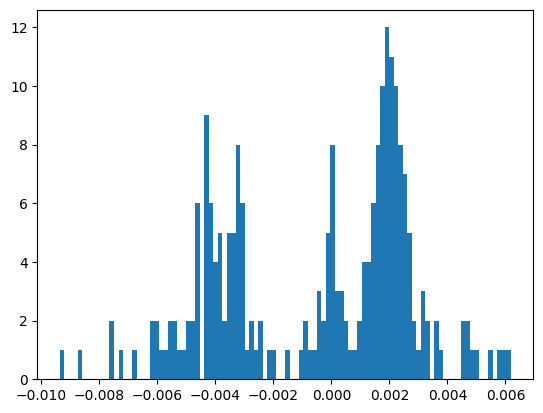

In [66]:
plt.hist(trade_df['Trade Return'], bins=100)
# plt.plot(trade_df['Trade Return'].cumsum())

In [ ]:
def trade_position(
    df: pd.DataFrame,
    indicators: List[pd.Series],
    log: dict
) -> None:
    """
    df: trade_log dataframe
    """
    _, ax = plt.subplots(figsize=(16, 6))
    df["close"].plot(
        label="Close Price",
        ax=ax,
        color="grey",
        grid=True,
        alpha=0.8
    )

    for indicator in indicators:
        indicator.plot(
            label="Indicator",
            ax=ax,
            color="blue",
            grid=True,
            alpha=0.8
        )

    for signal in log.keys():
        color = "orangered" if signal in ["long", "sell"] else "limegreen"
        marker = "^" if signal in ["long", "buytocover"] else "v"
        plt.scatter(
            df['close'].iloc[log[signal]].index,
            df['close'].iloc[log[signal]],
            color=color,
            label=signal,
            marker=marker,
            s=60
        )
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Trade Position", fontsize=15)
    plt.show()